# Final Project Logistic Regression Model

# Datascience DIKU 2021

This notebook documents some of our work on deep models for predicting fake news from the FakeNewsCorpus. We go through a simple sequential binary classification model, before moving on to Long Short Term Memory model, before applying a Global Vector embedding matrix on both. We choose which models to run and with what data at the start of the notebook. Scores are printed near the end, as well as preparing and predicing on data from the LIAR and Kaggle dataset.

In [73]:
from sklearn.model_selection import train_test_split

import time
import pandas as pd
import numpy as np

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from multiprocessing import Pool
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams['figure.figsize'] = [10,10]
import seaborn as sns
sns.set_theme(style="darkgrid")

from LoadingAndCleaning import init_dataframe
import LoadingAndCleaning

# TODOs
1. Put all or some functions into py file?
2. Document
3. Consider playing with other models

In [2]:
def load_trim_and_process_df(percent_load, load_path, use_multiprocessing=True, is_clean_authors_and_title=False): 
   
    raw_df = init_dataframe(load_path, percent_load)
    df = LoadingAndCleaning.trim_and_clean_df(raw_df, use_multiprocessing, is_clean_authors_and_title)
    #df = LoadingAndCleaning.drop_empty_string_rows(df)
    df = LoadingAndCleaning.process_df(df)

    return df

In [3]:
def load_trim_and_process_df_only_content(percent_load, load_path, use_multiprocessing, is_clean_authors_and_title=False, only_content=True): 
   
    raw_df = init_dataframe(load_path, percent_load)
    df = LoadingAndCleaning.trim_and_clean_df_only_content(raw_df)
    #df = LoadingAndCleaning.drop_empty_string_rows(df)
    df = LoadingAndCleaning.process_df_only_content(df)

    return df

In [4]:
def init_and_fit_tokenizer(raw_df, use_all_info=False):
    # Fill nans with empty strings, and append title and author to content
    df = raw_df.fillna('')
    
    tokenizer = Tokenizer(oov_token = "<OOV>", num_words=6000)
        
    if use_all_info:
        df['all_info'] = df['content'] + df['title'] + df['authors']
        tokenizer.fit_on_texts(df['all_info'])
        
    else: 
        tokenizer.fit_on_texts(df['content_joined'])

    # save labels in target
    target = df['label'].values
    
    return df, tokenizer, target

In [5]:
def adjust_df_labels_remove_fake(df): 
    df_real = df[df['label'] == 1]
    df_fake = df[df['label'] == 0]
    min_len = len(df_real)
    df_adjusted = df_real.append(df_fake.sample(n=min_len))
    
    return df_adjusted

In [6]:
def get_padded_training_sequence(df, feature, tokenizer):
    #%%time
    max_length = 40
    #c = 6000

    use_all_info = False
    if use_all_info:
        # Tokenize text to sequences
        sequences_train = tokenizer.texts_to_sequences(df[feature])
        #sequences_test = tokenizer.texts_to_sequences(test_df['all_info'])
    else:
        sequences_train = tokenizer.texts_to_sequences(df[feature])

    padded_train = pad_sequences(sequences_train, padding = 'post', maxlen=max_length)
    #padded_test = pad_sequences(sequences_test, padding = 'post', maxlen=max_length)
    return padded_train

# 0. Important commands: Decide which models are run here

In [7]:
# Command center: Decide what model to train here
load_and_train_simple_binary_classifier = True
load_and_train_LSTM_model = True

# will fix this, always using glove for the two below
using_GloVe = True
load_and_train_GloVe_BC_model = True
load_and_train_LSTM_GloVe_model = True


use_all_info = False

# 1.1 Load data, trim, clean, process, ONLY content and label

In [8]:
#####################################
#   Change "percent_load"           #
#        to increase rows in data   #
#####################################

percent_load = 0.1
load_path = 'data/1mio-raw.csv'
use_multiprocessing = True
is_clean_authors_and_title = True # Wups, not treated ideally? (cleaned like content)

df = init_dataframe(load_path, percent_load)
df['content'] = df['content'].astype('str')
#df['label'] = np.where(((df['type'] == 'political') | (raw_df['type'] == 'reliable')), 1, 0)
df = df[df.type != "unknown"]

df = LoadingAndCleaning.trim_df_only_content(df)
df = adjust_df_labels_remove_fake(df)
df = LoadingAndCleaning.clean_df_only_content(df, use_multiprocessing)
df = LoadingAndCleaning.process_df_only_content(df, use_multiprocessing)

Initializing dataframe...
Initialized data (100906 entries) in: 6.2 seconds
Trimming entries...
Cleaning...
Cleaned (51832 entries) in: 43.7 seconds
Processing...
Im using multiprocessing :)
Processed(51832 entries) in: 30.0 seconds


In [9]:
df['type'].value_counts()

political     25253
fake           7260
bias           6213
conspiracy     4492
rumor          2868
unreliable     2081
clickbait      1446
junksci         874
reliable        663
satire          473
hate            209
Name: type, dtype: int64

In [10]:
df

,type,content,label,content_joined,content_length
8,reliable,"[photo, reuters, teams, north, south, korea, m...",1,photo reuters teams north south korea march st...,307
28,political,"[peace, forgotten, belong, mother, teresa, fri...",1,peace forgotten belong mother teresa friday ni...,17
51,reliable,"[photo, reutershannah, mckay, priest, wears, r...",1,photo reutershannah mckay priest wears rainbow...,296
55,political,"[enderly, park, blistering, unseasonable, sept...",1,enderly park blistering unseasonable september...,23
62,political,"[fox, news, personality, todd, starnes, attrib...",1,fox news personality todd starnes attributed d...,545
...,...,...,...,...,...
26849,conspiracy,"[lying, australian, pm, wanted, shirt, front, ...",0,lying australian pm wanted shirt front putin c...,81
55776,bias,"[eu, launch, military, operation, central, afr...",0,eu launch military operation central african r...,59
46965,rumor,"[february, integration, minister, inger, støjb...",0,february integration minister inger støjberg a...,164
42485,bias,"[may, aware, cops, simply, steal, yes, exactly...",0,may aware cops simply steal yes exactly correc...,270


## 1.2 Init and fit tokenizer

In [11]:
use_all_info = False
df, trained_tokenizer, target = init_and_fit_tokenizer(df, use_all_info)

### 1.3 Get training_sequence and split data

In [12]:
padded_train = get_padded_training_sequence(df, "content_joined", trained_tokenizer)

In [13]:
# Split the padded training data and target vals into train and test
X_train, X_test, y_train, y_test = train_test_split(padded_train, target, test_size=0.2)

In [14]:
X_train.shape, y_train.shape

((41465, 40), (41465,))

# 2. First a simple Binary Classification model, using keras

In [15]:
def get_simple_model(max_length = 40, vocab_size = 6000):
    model = Sequential()
    model.add(Embedding(vocab_size, 10, input_length=max_length))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [16]:
def get_callbacks(filepath):
    callbacks=[
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, 
                                  verbose=1, mode="min", restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True)
    ]
    return callbacks

In [17]:
def init_binary_classification_model():
    # Init model name and save
    best_binary_clf_file_name = "models/best_model_binary_clf.hdf5"

    # Init callbacks for early stopping (based on validation loss)
    callbacks= get_callbacks(best_binary_clf_file_name)

    # Print the params of the model
    model = get_simple_model()
    model.summary()
    return model, callbacks, best_binary_clf_file_name

In [18]:
def compile_model(model, opt='adam', loss_fn= 'binary_crossentropy'):
    # Init the model with binary cross entropy loss, adam optimizer, looking at precision and recall
    #loss_fn = 'binary_crossentropy'
    #opt = keras.optimizers.Adam(learning_rate=0.01)
    #opt = 'adam'
    #loss_fn=tf.keras.losses.Poisson()
    #tf.keras.losses.Poisson()
    model.compile(loss=loss_fn,
                  optimizer=opt, 
                  metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

In [19]:
def train_and_get_history_deep_model(model, callbacks, X_train, y_train, X_test, y_test, epochs=20):
    #%%time
    history = model.fit(X_train, 
                        y_train, 
                        epochs=epochs,
                        validation_data=(X_test, y_test), 
                        callbacks=callbacks)
    
    return history

In [20]:
def print_scores(model, X_test, y_test, X_train, y_train): # add model, or filepath (and load) here?
    #model = keras.models.load_model(best_model_file_name)
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    y_pred_train = (model.predict(X_train) > 0.5).astype("int32")
    print("Scores for ", model)
    print('Accuracy Train: ', accuracy_score(y_train, y_pred_train))
    print('Accuracy Test: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred))
    print('Recall: ', recall_score(y_test, y_pred))
    print('F1 Score: ', f1_score(y_test, y_pred))

In [21]:
X_test

array([[   4,  139,  193, ...,  536,   82,    1],
       [1226,   61,    1, ...,  645,  340, 4443],
       [   5, 2044, 5467, ..., 1265,  262,    1],
       ...,
       [ 104,   82, 2723, ...,  734,  231,  195],
       [   1,    1, 2735, ...,    0,    0,    0],
       [ 924, 4361,  572, ...,    1,  195,    0]])

## 2.1 Define and compile model

In [22]:
if load_and_train_simple_binary_classifier:
    binary_clf_model, binary_clf_callbacks, best_binary_clf_file_name = init_binary_classification_model()

    binary_clf_model = compile_model(binary_clf_model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 10)            60000     
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 401       
Total params: 60,401
Trainable params: 60,401
Non-trainable params: 0
_________________________________________________________________


## 2.2 Run BC model

In [23]:
%%time
if load_and_train_simple_binary_classifier:
    #%time
    binary_clf_history = train_and_get_history_deep_model(binary_clf_model,
                                                          binary_clf_callbacks,
                                                          X_train,
                                                          y_train,
                                                          X_test,
                                                          y_test)

Epoch 1/20
1296/1296 [==============================] - 2s 935us/step - loss: 0.4929 - precision: 0.7451 - recall: 0.7619 - val_loss: 0.3972 - val_precision: 0.7822 - val_recall: 0.8562

Epoch 00001: val_loss improved from inf to 0.39718, saving model to models\best_model_binary_clf.hdf5
Epoch 2/20
1296/1296 [==============================] - 1s 725us/step - loss: 0.3412 - precision: 0.8241 - recall: 0.8793 - val_loss: 0.3851 - val_precision: 0.7903 - val_recall: 0.8543

Epoch 00002: val_loss improved from 0.39718 to 0.38509, saving model to models\best_model_binary_clf.hdf5
Epoch 3/20
1296/1296 [==============================] - 1s 737us/step - loss: 0.2744 - precision: 0.8696 - recall: 0.9117 - val_loss: 0.3998 - val_precision: 0.8024 - val_recall: 0.8216

Epoch 00003: val_loss did not improve from 0.38509
Epoch 4/20
1296/1296 [==============================] - 1s 723us/step - loss: 0.2143 - precision: 0.9080 - recall: 0.9392 - val_loss: 0.4289 - val_precision: 0.7988 - val_recall: 0

In [24]:
if load_and_train_simple_binary_classifier: 
    binary_clf_history.history.keys()

## 2.3 Vizualization of training and validation loss, precision

In [25]:
def line_plot_metric(metric, title, history):
    metric_to_plot = metric
    plt.plot(range(1, max(history.epoch) + 2), history.history[metric_to_plot], ".:", label="Training loss")
    plt.plot(range(1, max(history.epoch) + 2), history.history["val_" + metric_to_plot], ".:", label="Validation loss")
    plt.title(title)
    plt.xlim([1,max(history.epoch) + 2])
    plt.xticks(range(1, max(history.epoch) + 2))
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

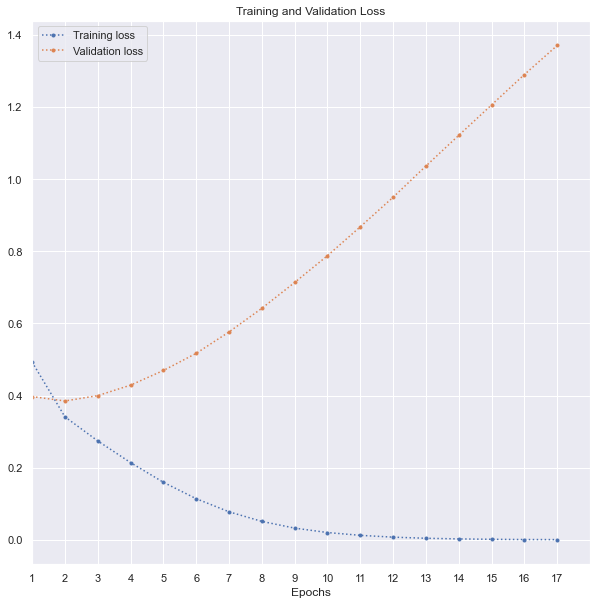

In [74]:
if load_and_train_simple_binary_classifier:
    line_plot_metric( "loss", "Training and Validation Loss", binary_clf_history)

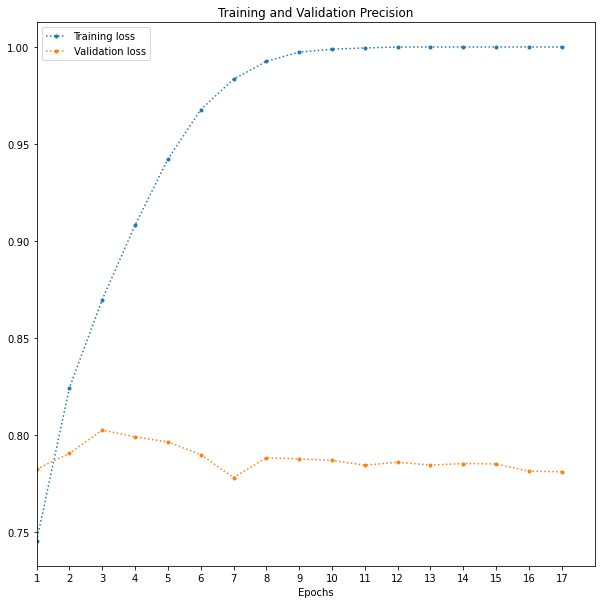

In [27]:
if load_and_train_simple_binary_classifier:
    line_plot_metric("precision", "Training and Validation Precision", binary_clf_history)

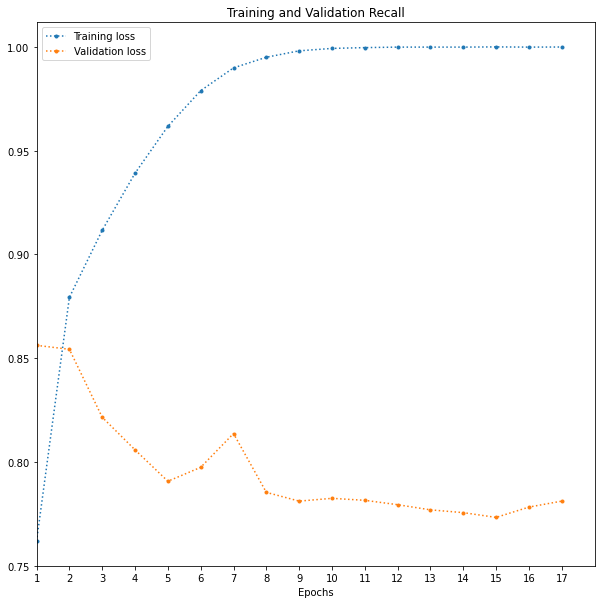

In [28]:
if load_and_train_simple_binary_classifier:
    line_plot_metric("recall", 'Training and Validation Recall', binary_clf_history)

## 2.4 Lets look at performance of the simple model
Compare this with base logistic model model. Consider having barchart with accuracy, precision, recall and f1score,
and have a bar for each model

In [29]:
if load_and_train_simple_binary_classifier:
    print_scores(binary_clf_model, X_test, y_test, X_train, y_train)

Scores for  <tensorflow.python.keras.engine.sequential.Sequential object at 0x00000272D6967B20>
Accuracy Train:  0.8969733510189316
Accuracy Test:  0.8123854538439278
Precision:  0.7902940134608573
Recall:  0.8542982959984683
F1 Score:  0.8210506946361211


 # 3. Now lets try LSTM Network for Text Classification.
 (Long Short-Term Memory), type of recurrent neural network

In [30]:
def get_simple_LSTM_model(max_length=40, vocab_size=6000):
    model = Sequential()
    model.add(Embedding(vocab_size, 10, input_length=max_length))
    model.add(Dropout(0.3))
    model.add(LSTM(100))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [31]:
def init_lstm_clf_model():
    best_lstm_clf_file_name = "models/best_model_simple_LSTM.hdf5"

    callbacks= get_callbacks(best_lstm_clf_file_name)

    model = get_simple_LSTM_model()
    #print(model.summary())

    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
    return model, callbacks, best_lstm_clf_file_name

In [32]:
if load_and_train_LSTM_model:
    lstm_model, lstm_callbacks, best_lstm_clf_file_name = init_lstm_clf_model()

In [33]:
if load_and_train_LSTM_model:
    lstm_clf_history = train_and_get_history_deep_model(lstm_model, lstm_callbacks, X_train, y_train, X_test, y_test)

Epoch 1/20
1296/1296 [==============================] - 16s 11ms/step - loss: 0.4586 - precision_1: 0.7365 - recall_1: 0.8233 - val_loss: 0.3997 - val_precision_1: 0.7473 - val_recall_1: 0.9177

Epoch 00001: val_loss improved from inf to 0.39967, saving model to models\best_model_simple_LSTM.hdf5
Epoch 2/20
1296/1296 [==============================] - 14s 11ms/step - loss: 0.3709 - precision_1: 0.7945 - recall_1: 0.8735 - val_loss: 0.3933 - val_precision_1: 0.7678 - val_recall_1: 0.8830

Epoch 00002: val_loss improved from 0.39967 to 0.39333, saving model to models\best_model_simple_LSTM.hdf5
Epoch 3/20
1296/1296 [==============================] - 13s 10ms/step - loss: 0.3424 - precision_1: 0.8161 - recall_1: 0.8814 - val_loss: 0.3974 - val_precision_1: 0.7904 - val_recall_1: 0.8396

Epoch 00003: val_loss did not improve from 0.39333
Epoch 4/20
1296/1296 [==============================] - 14s 11ms/step - loss: 0.3247 - precision_1: 0.8277 - recall_1: 0.8879 - val_loss: 0.4028 - val_pre

## 3.1 Now vizualisation of LSTM loss
Remember we want the validation loss to be minimized, so it doesnt matter that training decreases if validation does not

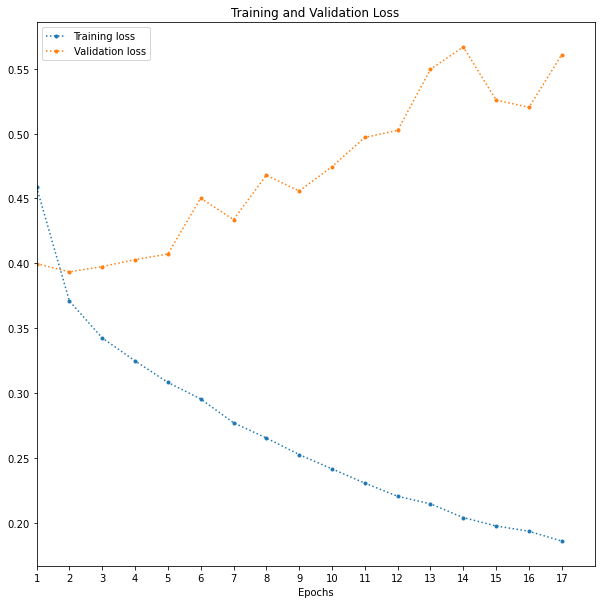

In [34]:
if load_and_train_LSTM_model:
    line_plot_metric( "loss", "Training and Validation Loss", lstm_clf_history)

## 3.2 Print LSTM Scores

In [35]:
if load_and_train_LSTM_model: 
    print_scores(lstm_model, X_test, y_test, X_train, y_train)

Scores for  <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000027382475610>
Accuracy Train:  0.8661039430845291
Accuracy Test:  0.8065013986688531
Precision:  0.7677709339104378
Recall:  0.8830174229370094
F1 Score:  0.8213713268032058


# 4. Now lets try with the pre-trained GloVe Embedding.
Use it both for glove and add it to LSTM.

Global vectors for word represenation

In [36]:
# Using https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

In [37]:
# User Guide:
# Download: 'http://nlp.stanford.edu/data/glove.6B.zip'
# Unzip and place in 'data' folder

In [38]:
def get_embeddings_index():
    time_start = time.time()
    embeddings_index = dict()
    # f = open('/content/glove.6B.300d.txt')
    f = open('data/glove.6B/glove.6B.300d.txt', encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    time_end = time.time()
    print('Loaded {} word vectors.'.format(len(embeddings_index)), "in seconds: ",(time_end - time_start))
    return embeddings_index

In [39]:
def get_embedding_matrix(tokenizer, embeddings_index):
    # create a weight matrix for words in training docs
    time_start = time.time()
    #print('Get vocab_size')
    vocab_size = len(tokenizer.word_index) + 1

    print('Creating the embedding matrix...')
    embedding_matrix = np.zeros((vocab_size, 300))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
    time_end = time.time()
    print('Created embedding matrix in seconds:' ,(time_end - time_start))
    return embedding_matrix

In [40]:
if using_GloVe:
    embeddings_index = get_embeddings_index()

Loaded 400000 word vectors. in seconds:  29.33614206314087


In [41]:
if using_GloVe:
    embedding_matrix = get_embedding_matrix(trained_tokenizer, embeddings_index)

Creating the embedding matrix...
Created embedding matrix in seconds: 0.2818107604980469


# 5. Now lets try adding GloVe embedding matrix to binary clf model

In [42]:
def get_simple_GloVe_model(embedding_matrix, tokenizer):
    max_length = 40
    vocab_size = len(tokenizer.word_index) + 1
    model = Sequential()
    model.add(Embedding(vocab_size, 
                        300, 
                        weights=[embedding_matrix], 
                        input_length=max_length,
                        trainable=False))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [43]:
if load_and_train_GloVe_BC_model:
    best_bc_GloVe_model_file_name = "models/best_model_binary_clf_with_GloVe.hdf5"

In [44]:
if load_and_train_GloVe_BC_model:
    bc_GloVe_callbacks = get_callbacks(best_bc_GloVe_model_file_name)

In [45]:
if load_and_train_GloVe_BC_model:
    binary_clf_GloVe_model = get_simple_GloVe_model(embedding_matrix, trained_tokenizer)

In [46]:
if load_and_train_GloVe_BC_model:
    binary_clf_GloVe_model = compile_model(binary_clf_GloVe_model)

## 5.1 Load and train BC with glove

In [47]:
%%time
if load_and_train_GloVe_BC_model:
    bc_GloVe_model_history = train_and_get_history_deep_model(binary_clf_GloVe_model,
                                                              bc_GloVe_callbacks,
                                                              X_train,
                                                              y_train,
                                                              X_test,
                                                              y_test,
                                                              epochs=50,)

Epoch 1/50
1296/1296 [==============================] - 3s 2ms/step - loss: 0.5174 - precision_2: 0.7250 - recall_2: 0.7446 - val_loss: 0.4977 - val_precision_2: 0.7562 - val_recall_2: 0.7352

Epoch 00001: val_loss improved from inf to 0.49767, saving model to models\best_model_binary_clf_with_GloVe.hdf5
Epoch 2/50
1296/1296 [==============================] - 1s 1ms/step - loss: 0.4440 - precision_2: 0.7728 - recall_2: 0.7970 - val_loss: 0.5169 - val_precision_2: 0.7307 - val_recall_2: 0.8030

Epoch 00002: val_loss did not improve from 0.49767
Epoch 3/50
1296/1296 [==============================] - 1s 1ms/step - loss: 0.4200 - precision_2: 0.7906 - recall_2: 0.8150 - val_loss: 0.5635 - val_precision_2: 0.7711 - val_recall_2: 0.6630

Epoch 00003: val_loss did not improve from 0.49767
Epoch 4/50
1296/1296 [==============================] - 1s 1ms/step - loss: 0.4089 - precision_2: 0.7978 - recall_2: 0.8194 - val_loss: 0.5680 - val_precision_2: 0.7260 - val_recall_2: 0.7992

Epoch 00004: 

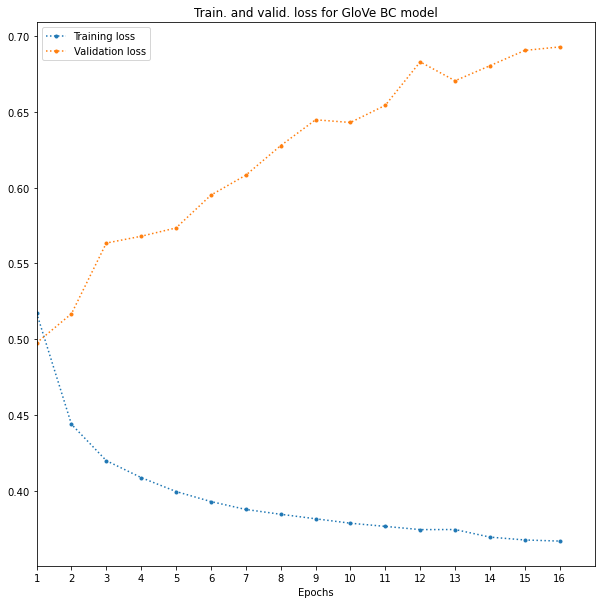

In [48]:
if load_and_train_GloVe_BC_model:
    line_plot_metric("loss", "Train. and valid. loss for GloVe BC model", bc_GloVe_model_history)

In [49]:
if load_and_train_GloVe_BC_model:
    print_scores(binary_clf_GloVe_model,X_test, y_test, X_train, y_train)

Scores for  <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000027293800640>
Accuracy Train:  0.8138912335704811
Accuracy Test:  0.7471785473135912
Precision:  0.7562032296179598
Recall:  0.7352096496266514
F1 Score:  0.7455586836229492


# 6.0 Now lets try adding GloVe embedding matrix to LSTM

In [50]:
## Note: vocab_size is = len(tokenizer.word_index) + 1 for glove models

In [51]:
def get_LSTM_GloVe_model(embedding_matrix, tokenizer, max_length=40):
    vocab_size = len(tokenizer.word_index) + 1
    model = Sequential()
    model.add(Embedding(vocab_size, 
                        300, 
                        weights=[embedding_matrix], 
                        input_length=max_length,
                        trainable=False))
    model.add(LSTM(100))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [52]:
if load_and_train_LSTM_GloVe_model: 
    best_LSTM_GloVe_model_file_name = "models/best_model_LSTM_clf_with_GloVe.hdf5"

In [53]:
if load_and_train_LSTM_GloVe_model: 
    LSTM_GloVe_callbacks = get_callbacks(best_LSTM_GloVe_model_file_name)

In [54]:
if load_and_train_LSTM_GloVe_model: 
    LSTM_GloVe_model = get_LSTM_GloVe_model(embedding_matrix, trained_tokenizer)

In [55]:
#LSTM_GloVe_model.summary()

## 6.1 Load and train LSTM with GloVe

In [56]:
if load_and_train_LSTM_GloVe_model: 
    opt = keras.optimizers.Adam(learning_rate=0.01)
    LSTM_GloVe_model = compile_model(LSTM_GloVe_model, opt)

In [57]:
%%time
if load_and_train_LSTM_GloVe_model: 
    LSTM_GloVe_model_history = train_and_get_history_deep_model(LSTM_GloVe_model,
                                                              LSTM_GloVe_callbacks,
                                                              X_train,
                                                              y_train,
                                                              X_test,
                                                              y_test,
                                                              epochs=15,)

Epoch 1/15
1296/1296 [==============================] - 26s 18ms/step - loss: 0.4726 - precision_3: 0.7146 - recall_3: 0.8285 - val_loss: 0.4178 - val_precision_3: 0.7458 - val_recall_3: 0.8729

Epoch 00001: val_loss improved from inf to 0.41777, saving model to models\best_model_LSTM_clf_with_GloVe.hdf5
Epoch 2/15
1296/1296 [==============================] - 21s 17ms/step - loss: 0.4229 - precision_3: 0.7473 - recall_3: 0.8572 - val_loss: 0.4092 - val_precision_3: 0.7661 - val_recall_3: 0.8558

Epoch 00002: val_loss improved from 0.41777 to 0.40925, saving model to models\best_model_LSTM_clf_with_GloVe.hdf5
Epoch 3/15
1296/1296 [==============================] - 22s 17ms/step - loss: 0.3964 - precision_3: 0.7689 - recall_3: 0.8671 - val_loss: 0.4033 - val_precision_3: 0.7556 - val_recall_3: 0.8855

Epoch 00003: val_loss improved from 0.40925 to 0.40331, saving model to models\best_model_LSTM_clf_with_GloVe.hdf5
Epoch 4/15
1296/1296 [==============================] - 29s 23ms/step - lo

In [58]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams['figure.figsize'] = [10, 10]
import seaborn as sns
sns.set_theme(style="darkgrid")

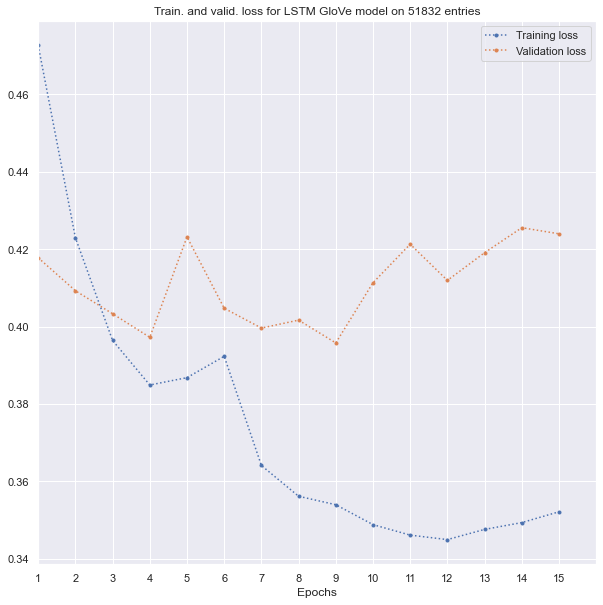

In [59]:
title = "Train. and valid. loss for LSTM GloVe model on {} entries".format(len(df))
if load_and_train_LSTM_GloVe_model: 
    line_plot_metric("loss", title, LSTM_GloVe_model_history)

## 6.2 Important: Scores for model

In [60]:
if load_and_train_LSTM_GloVe_model:
    print_scores(LSTM_GloVe_model, X_test, y_test, X_train, y_train)

Scores for  <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000027293613040>
Accuracy Train:  0.8616664656939588
Accuracy Test:  0.7983023053921096
Precision:  0.7744479495268138
Recall:  0.8460654796094199
F1 Score:  0.8086741696404062


# 7.  Predict on LIAR

In [61]:
def prepare_liar():
    liar_path = "data/liar_dataset/test.tsv"
    liar_df = pd.read_csv(liar_path, sep='\t', names=["ID", "label", "statement", "subject", "speaker", "job title", "state ", "party ","total credit", "barely true counts","false counts", "half true counts", "mostly true counts", "pants on fire counts","context "])
    liar_df['custom_label'] = np.where(((liar_df['label'] == 'true') | (liar_df['label'] == 'mostly-true')), 1, 0)
    liar_df = liar_df.dropna(subset=['label', 'statement'])
    liar_df['statement'] = liar_df['statement'].str.strip()
    liar_df = liar_df.drop_duplicates(subset="statement") 
    liar_df["statement"] = pd.concat(map(LoadingAndCleaning.clean_content, np.array_split(liar_df["statement"], 32)))
    liar_df["statement"] = pd.concat(map(LoadingAndCleaning.clean_content, np.array_split(liar_df["statement"], 32)))
    liar_df["statement"] = pd.concat(map(LoadingAndCleaning.tokenize, np.array_split(liar_df["statement"], 32)))
    liar_df["statement"] = pd.concat(map(LoadingAndCleaning.remove_stopwords, np.array_split(liar_df["statement"], 32)))
    liar_df["statement_joined"] = pd.concat(map(LoadingAndCleaning.recombine_content, np.array_split(liar_df["statement"], 32)))
    liar_df["statement_len"] = pd.concat(map(LoadingAndCleaning.add_content_length, np.array_split(liar_df["statement"], 32)))
    return liar_df

In [62]:
def pre_process_LIAR_deep_models(raw_df, feature, use_labels=False):
    # Fill nans with empty strings, and append title and author to content
    df = raw_df.fillna('')
    
    tokenizer = Tokenizer(oov_token = "<OOV>", num_words=6000)
    tokenizer.fit_on_texts(df[feature])
   

    #Add a label (1) to political, reliable and 0 to everything else
    #df['label'] = np.where(((df['type'] == 'political') | (df['type'] == 'reliable')), 1, 0)

    # save labels in target
    if use_labels:
        target = df['label'].values
        return df, tokenizer, target
    else:
        return df

In [63]:
def format_and_print_LIAR_scores(model, trained_tokenizer, X_train, y_train):
    liar_df = prepare_liar()
    feature = "statement_joined"
    liar_targets = liar_df['custom_label'].values
    #liar_targets, liar_tokenizer, liar_targets = pre_process_for_testing_deep_models(liar_df, feature, trained_tokenizer, label="custom_label", use_labels=True)
    X_padded_liar = get_padded_training_sequence(liar_df, feature, trained_tokenizer)
    print_scores(model, X_padded_liar, liar_targets, X_train, y_train)

## 7.1 Important: Scores for LIAR

In [64]:
# Change to your model name here
model = binary_clf_model
format_and_print_LIAR_scores(model, trained_tokenizer, X_train, y_train)

Scores for  <tensorflow.python.keras.engine.sequential.Sequential object at 0x00000272D6967B20>
Accuracy Train:  0.8969733510189316
Accuracy Test:  0.3638516179952644
Precision:  0.3538083538083538
Recall:  0.9621380846325167
F1 Score:  0.5173652694610779


# 8. Predict on Kaggle

In [65]:
# Adjustable cleaner
def custom_clean(df, feature):
    feature_joined = feature + "_joined"
    df[feature] = pd.concat(map(LoadingAndCleaning.clean_content, np.array_split(df[feature], 32)))
    df[feature] = pd.concat(map(LoadingAndCleaning.tokenize, np.array_split(df[feature], 32)))
    df[feature] = pd.concat(map(LoadingAndCleaning.remove_stopwords, np.array_split(df[feature], 32)))
    df[feature_joined] = pd.concat(map(LoadingAndCleaning.recombine_content, np.array_split(df[feature], 32)))
    return df

In [66]:
def prepare_kaggle():
    kaggle_path = "data/kaggle_test_data/test_set.json"
    kaggle_df = pd.read_json(kaggle_path)
    kaggle_df = custom_clean(kaggle_df, "article")
    return kaggle_df

In [67]:
def get_kaggle_submission(model):
    kaggle_df = prepare_kaggle()
    kaggle_feature = "article_joined"
    X_padded_kaggle = get_padded_training_sequence(kaggle_df, kaggle_feature, trained_tokenizer)
    kaggle_predictions = (model.predict(X_padded_kaggle) > 0.5).astype("int32")
    
    kaggle_submission = kaggle_df
    kaggle_submission['label'] = kaggle_predictions.tolist()
    kaggle_submission = kaggle_submission.drop(['article', 'article_joined'], axis=1)
    kaggle_submission['label'] = kaggle_submission['label'].apply(lambda x: x[0])
    kaggle_submission['label'] = np.where(((kaggle_submission['label'] == 1)), "REAL", "FAKE")
    return kaggle_submission

In [68]:
# Change to your model name here
kaggle_submission = get_kaggle_submission(model)

## 8.1 Important: Kaggle predictions

In [69]:
kaggle_submission

,id,label
0,8476,REAL
1,10294,REAL
2,3608,FAKE
3,10142,REAL
4,875,REAL
...,...,...
6330,4490,REAL
6331,8062,REAL
6332,8622,FAKE
6333,4021,REAL


# Save kaggle preds, remember not to overwrite

In [70]:
# Put kaggle subs into 'data/submission/yourname.csv'
#kaggle_path = "data/submissions/yournamehere.csv"
#kaggle_submission.to_csv(kaggle_path, index=False)

In [71]:
#kaggle_submission

In [72]:
#:)